In [1]:
import numpy as np
from numpy import random
import pickle
import os
import pathlib

from Performance import DDR_Problem_Evaluation
ddr_eva = DDR_Problem_Evaluation()
from OLS import OLS_Related_Estimation
from DDR_Estimation import DDR_Method
from SPO import SPO_Plus_Method
from Data import DataSimulator

## Generate Data

In [2]:
def generate_data(DataPath,iters,lower, upper, p, d, data_generation_process,
                  samples_test, samples_train, alpha, n_epsilon, mis, thres, x_dister, e_dister, xl, xu, xm, xv, bp):

    data_simu = DataSimulator()
    Data = {}
    for i in range(iters):
        # print("============== iteration = ",i,"==============")
        file_path = DataPath + "iter="+str(i) +"/"
        pathlib.Path(file_path).mkdir(parents=True, exist_ok=True)
        # o uniform, 1 binary, 2 uniform + feature, 3 binary + feature, 4 sparse, 5 012
        W_star = data_simu.generate_truth(lower, upper, p, d, data_generation_process) 
        Data[i] = data_simu.generate_samples(file_path,p, d, samples_test, samples_train, alpha, W_star, n_epsilon, mis, thres, 
                            data_generation_process, x_dister, e_dister, xl, xu, xm, xv, bp) 
    return Data

## Oracle

In [3]:
def Implement_Oracle(iters,Data,data_generation_process,DataPath,fold_name):
    Data_path_child = DataPath + fold_name
    cost_Oracle_wo_noise_all = {}
    for i in range(iters):
        x_test, z_test_ori, z_test, x_train, z_train_ori, z_train, W_star = Data[i]
        cost_Oracle_wo_noise_all[i] = ddr_eva.compute_DDR_out_of_sample_Cost(z_test_ori,z_test_ori,z_test-z_test_ori,data_generation_process,False)
        # if i % 10 == 0:
        #     print(fold_name,",iteration = ",i,",c_oracle_without_noise = ",np.nanmean(cost_Oracle_wo_noise_all[i]))
    with open(Data_path_child+'cost_Oracle_wo_noise_all.pkl', "wb") as tf:
        pickle.dump(cost_Oracle_wo_noise_all,tf)
    return cost_Oracle_wo_noise_all

## OLS

In [4]:
def Implement_OLS(iters,Data,data_generation_process,DataPath,fold_name):
    Data_path_child = DataPath + fold_name
    ORE = OLS_Related_Estimation()
    cost_OLS_wo_noise_all = {}
    for i in range(iters):
        x_test, z_test_ori, z_test, x_train, z_train_ori, z_train, W_star = Data[i]
        W_ols, w0_ols, t_ols, obj_ols = ORE.OLS_Solver("",x_train, z_train)
        cost_pred = (W_ols @ x_test.T).T + w0_ols
        cost_OLS_wo_noise_all[i] = ddr_eva.compute_DDR_out_of_sample_Cost(cost_pred,z_test_ori,z_test-z_test_ori,data_generation_process,False)
        # if i % 10 == 0:
        #     print(fold_name,",iteration = ",i,",c_OLS_without_noise = ",np.nanmean(cost_OLS_wo_noise_all[i]))
    with open(Data_path_child+'cost_OLS_wo_noise_all.pkl', "wb") as tf:
        pickle.dump(cost_OLS_wo_noise_all,tf)

    return cost_OLS_wo_noise_all

## Lasso

In [5]:
def Implement_Lasso(iters,Data,data_generation_process,DataPath,fold_name):
    Data_path_child = DataPath + fold_name

    ORE = OLS_Related_Estimation()
    cost_Lasso_wo_noise_all = {}
    for i in range(iters):
        x_test, z_test_ori, z_test, x_train, z_train_ori, z_train, W_star = Data[i]
        W_lasso, w0_lasso, t_lasso = ORE.Lasso_Solver(x_train, z_train)
        cost_pred = (W_lasso @ x_test.T).T + w0_lasso
        cost_Lasso_wo_noise_all[i] = ddr_eva.compute_DDR_out_of_sample_Cost(cost_pred,z_test_ori,z_test-z_test_ori,data_generation_process,False)
        # if i % 10 == 0:
        #     print(fold_name,",iteration = ",i,",c_Lasso_without_noise = ",np.nanmean(cost_Lasso_wo_noise_all[i]))

    with open(Data_path_child+'cost_Lasso_wo_noise_all.pkl', "wb") as tf:
        pickle.dump(cost_Lasso_wo_noise_all,tf)
    return cost_Lasso_wo_noise_all

## Ridge

In [6]:
def Implement_Ridge(iters,Data,data_generation_process,DataPath,fold_name):
    Data_path_child = DataPath + fold_name

    ORE = OLS_Related_Estimation()
    cost_Ridge_wo_noise_all = {}
    for i in range(iters):
        x_test, z_test_ori, z_test, x_train, z_train_ori, z_train, W_star = Data[i]
        W_ridge, w0_ridge, t_ridge = ORE.Ridge_Solver(x_train, z_train)
        cost_pred = (W_ridge @ x_test.T).T + w0_ridge
        cost_Ridge_wo_noise_all[i] = ddr_eva.compute_DDR_out_of_sample_Cost(cost_pred,z_test_ori,z_test-z_test_ori,data_generation_process,False)
        # if i % 10 == 0:
        #     print(fold_name,",iteration = ",i,",c_Ridge_without_noise = ",np.nanmean(cost_Ridge_wo_noise_all[i]))
    with open(Data_path_child+'cost_Ridge_wo_noise_all.pkl', "wb") as tf:
        pickle.dump(cost_Ridge_wo_noise_all,tf)

    return cost_Ridge_wo_noise_all

## DDR

In [7]:
def Implement_DDR(iters,Data,data_generation_process,DataPath,fold_name,mu_all,lamb_all):
    Data_path_child = DataPath + fold_name
    DDR_Esti = DDR_Method()
    W_ddr_all = {}; w0_ddr_all = {}; obj_ddr_all = {}
    cost_DDR_wo_noise_all = {}
    for i in range(iters):
        x_test, z_test_ori, z_test, x_train, z_train_ori, z_train, W_star = Data[i]
        cost_ddr_avg_tem = np.zeros((len(mu_all),len(lamb_all)))
        for mu_index in range(len(mu_all)):
            mu = mu_all[mu_index]
            for lamb_index in range(len(lamb_all)):
                lamb = lamb_all[lamb_index]
                W_ddr_all[i,mu,lamb], w0_ddr_all[i,mu,lamb] = DDR_Esti.DDR_Solver(x_train, z_train, mu, lamb)
                cost_pred = (W_ddr_all[i,mu,lamb] @ x_test.T).T + w0_ddr_all[i,mu,lamb]
                cost_DDR_wo_noise_all[i,mu,lamb] = ddr_eva.compute_DDR_out_of_sample_Cost(cost_pred,z_test_ori,z_test-z_test_ori,data_generation_process,False)
        # if i % 10 == 0:
        #     print(fold_name,",iteration = ",i,",cost_DDR_wo_noise_all = ",np.nanmean(cost_DDR_wo_noise_all[i,mu,lamb]))

    with open(Data_path_child+'cost_DDR_wo_noise_all.pkl', "wb") as tf:
        pickle.dump(cost_DDR_wo_noise_all,tf)

    return cost_DDR_wo_noise_all

## SPO Plus

In [8]:
def Implement_SPO_plus(iters,Data,data_generation_process,DataPath,fold_name):
    Data_path_child = DataPath + fold_name

    SPM = SPO_Plus_Method()
    cost_SPO_wo_noise_all = {}
    for i in range(iters):
        x_test, z_test_ori, z_test, x_train, z_train_ori, z_train, W_star = Data[i]
        y_train_opt = ddr_eva.decision_finder(z_train) #generates the optimal y from the training costs
        W_spo, w0_spo, t_spo = SPM.Spo_Solver(x_train, z_train, y_train_opt)
        cost_pred = (W_spo @ x_test.T).T + w0_spo
        cost_SPO_wo_noise_all[i] = ddr_eva.compute_DDR_out_of_sample_Cost(cost_pred,z_test_ori,z_test-z_test_ori,data_generation_process,False)
        # if i % 10 == 0:
        #     print(fold_name,",iteration = ",i,",cost_SPO_wo_noise_all = ",np.nanmean(cost_SPO_wo_noise_all[i]))
    with open(Data_path_child+'cost_SPO_wo_noise_all.pkl', "wb") as tf:
        pickle.dump(cost_SPO_wo_noise_all,tf)

    return cost_SPO_wo_noise_all

## Comparison

In [9]:
seed = 3
random.seed(seed)
iters = 100
samples_test = 10000
thres = samples_test
lower = 0
upper = 1
n_epsilon = 1
mis = 1
x_dister = 'uniform'
e_dister = 'normal'
xl = -2
xu = 2
xm = 2
xv = 0.25
bp = 7

mu_all = np.round(np.arange(0.25,0.251,0.1),4)
lamb_all = np.round(np.arange(0.25,0.251,0.1),4)
data_generation_process = "DDR_Data_Generation"

current_directory = os.getcwd()
project_directory = os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(current_directory))))
DataPath = project_directory + "/Data_JOC_R1/DDR/Figure_D5/"
print("DataPath:", DataPath)
pathlib.Path(DataPath).mkdir(parents=True, exist_ok=True)

DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/DDR/Figure_D5/


In [10]:
def compute_regret_h2h(iters,cost_item,cost_base,cost_oracle,mu, lamb,ddr_eva,is_item_ddr,is_base_ddr):
    h2h = np.zeros(iters); cost_reduction = np.zeros(iters); regret_reduction = np.zeros(iters)
    for i in range(iters):
        if is_item_ddr:
            cost_item_input = cost_item[i, mu, lamb]
        else:
            cost_item_input = cost_item[i]
        if is_base_ddr:
            cost_base_input = cost_base[i, mu, lamb]
        else:
            cost_base_input = cost_base[i]
        lbel, h2h[i], cost_reduction[i], regret_reduction[i] = ddr_eva.cross_compare2plus(cost_item_input,cost_base_input,cost_oracle[i])
    regret_rd_prop = np.round( len(regret_reduction[regret_reduction > 0.0])/len(regret_reduction),4 )
    h2h_prop = np.round( len(h2h[h2h > 0.5])/len(h2h),4 )
    return h2h, cost_reduction, regret_reduction, regret_rd_prop, h2h_prop

## Impact of p

In [11]:
random.seed(seed)
mu = mu_all[0]
lamb = lamb_all[0]
d = 10
alpha = 1
samples_train = 100
p_all = [4,6,8,10]
Data_p = {}
for p in p_all:
    # random.seed(seed)
    fold_name = "samples_train="+str(samples_train)+"_p="+str(p)+"_d="+str(d)+"_alpha="+str(alpha)+"_new/"
    print(fold_name)
    Data_p[p] = generate_data(DataPath+fold_name,iters,lower, upper, p, d, data_generation_process, samples_test, samples_train, alpha, n_epsilon, mis, thres, x_dister, e_dister, xl, xu, xm, xv, bp)

samples_train=100_p=4_d=10_alpha=1_new/
samples_train=100_p=6_d=10_alpha=1_new/
samples_train=100_p=8_d=10_alpha=1_new/
samples_train=100_p=10_d=10_alpha=1_new/


In [12]:
mu = mu_all[0]
lamb = lamb_all[0]
d = 10
alpha = 1
samples_train = 100
p_all = [4,6,8,10]
h2h_ddr_ols_p = {}; cost_rd_ddr_ols_p = {}; regret_rd_ddr_ols_p = {}; h2h_ddr_ols_prop_p = np.zeros(len(p_all));regret_rd_ddr_ols_prop_p = np.zeros(len(p_all))
h2h_lasso_ols_p = {}; cost_rd_lasso_ols_p = {}; regret_rd_lasso_ols_p = {}; h2h_lasso_ols_prop_p = np.zeros(len(p_all));regret_rd_lasso_ols_prop_p = np.zeros(len(p_all))
h2h_ridge_ols_p = {}; cost_rd_ridge_ols_p = {}; regret_rd_ridge_ols_p = {}; h2h_ridge_ols_prop_p = np.zeros(len(p_all));regret_rd_ridge_ols_prop_p = np.zeros(len(p_all))
h2h_lasso_ddr_p = {}; cost_rd_lasso_ddr_p = {}; regret_rd_lasso_ddr_p = {}; h2h_lasso_ddr_prop_p = np.zeros(len(p_all));regret_rd_lasso_ddr_prop_p = np.zeros(len(p_all))
h2h_ridge_ddr_p = {}; cost_rd_ridge_ddr_p = {}; regret_rd_ridge_ddr_p = {}; h2h_ridge_ddr_prop_p = np.zeros(len(p_all));regret_rd_ridge_ddr_prop_p = np.zeros(len(p_all))

p_index = 0
for p in p_all:
    # random.seed(seed)
    fold_name = "samples_train="+str(samples_train)+"_p="+str(p)+"_d="+str(d)+"_alpha="+str(alpha)+"_new/"

    cost_Oracle_all = Implement_Oracle(iters,Data_p[p],data_generation_process,DataPath,fold_name)
    cost_OLS_all = Implement_OLS(iters,Data_p[p],data_generation_process,DataPath,fold_name)
    cost_DDR_all = Implement_DDR(iters,Data_p[p],data_generation_process,DataPath,fold_name,mu_all,lamb_all)
    cost_Lasso_all = Implement_Lasso(iters,Data_p[p],data_generation_process,DataPath,fold_name)
    cost_Ridge_all = Implement_Ridge(iters,Data_p[p],data_generation_process,DataPath,fold_name)

    h2h_ddr_ols_p[p_index], cost_rd_ddr_ols_p[p_index], regret_rd_ddr_ols_p[p_index], regret_rd_ddr_ols_prop_p[p_index], h2h_ddr_ols_prop_p[p_index] \
    = compute_regret_h2h(iters,cost_DDR_all,cost_OLS_all,cost_Oracle_all,mu, lamb,ddr_eva,True,False)

    h2h_lasso_ols_p[p_index], cost_rd_lasso_ols_p[p_index], regret_rd_lasso_ols_p[p_index], regret_rd_lasso_ols_prop_p[p_index], h2h_lasso_ols_prop_p[p_index] \
    = compute_regret_h2h(iters,cost_Lasso_all,cost_OLS_all,cost_Oracle_all,mu, lamb,ddr_eva,False,False)

    h2h_ridge_ols_p[p_index], cost_rd_ridge_ols_p[p_index], regret_rd_ridge_ols_p[p_index], regret_rd_ridge_ols_prop_p[p_index], h2h_ridge_ols_prop_p[p_index] \
    = compute_regret_h2h(iters,cost_Ridge_all,cost_OLS_all,cost_Oracle_all,mu, lamb,ddr_eva,False,False)

    h2h_lasso_ddr_p[p_index], cost_rd_lasso_ddr_p[p_index], regret_rd_lasso_ddr_p[p_index], regret_rd_lasso_ddr_prop_p[p_index], h2h_lasso_ddr_prop_p[p_index] \
    = compute_regret_h2h(iters,cost_Lasso_all,cost_DDR_all,cost_Oracle_all,mu, lamb,ddr_eva,False,True)

    h2h_ridge_ddr_p[p_index], cost_rd_ridge_ddr_p[p_index], regret_rd_ridge_ddr_p[p_index], regret_rd_ridge_ddr_prop_p[p_index], h2h_ridge_ddr_prop_p[p_index] \
    = compute_regret_h2h(iters,cost_Ridge_all,cost_DDR_all,cost_Oracle_all,mu, lamb,ddr_eva,False,True)

    print("p=",p,",h2h=",h2h_ddr_ols_prop_p[p_index],",regret=",regret_rd_ddr_ols_prop_p[p_index])
    p_index = p_index + 1


Set parameter Username
Academic license - for non-commercial use only - expires 2026-03-13
p= 4 ,h2h= 0.72 ,regret= 0.72
p= 6 ,h2h= 0.69 ,regret= 0.7
p= 8 ,h2h= 0.71 ,regret= 0.72
p= 10 ,h2h= 0.59 ,regret= 0.66


## Impact of d

In [13]:
mu = mu_all[0]
lamb = lamb_all[0]
d_all = [5,10,25,50]
alpha = 1
samples_train = 100
p = 4
h2h_d = np.zeros(len(d_all)); regret_d = np.zeros(len(d_all))
d_index = 0
Data_d = {}
for d in d_all:
    fold_name = "samples_train="+str(samples_train)+"_p="+str(p)+"_d="+str(d)+"_alpha="+str(alpha)+"_new/"
    if d != 10:
        Data_d[d] = generate_data(DataPath+fold_name,iters,lower, upper, p, d, data_generation_process,
            samples_test, samples_train, alpha, n_epsilon, mis, thres, x_dister, e_dister, xl, xu, xm, xv, bp)
    else:
        Data_d[d] = Data_p[p]

In [14]:
h2h_ddr_ols_d = {}; cost_rd_ddr_ols_d = {}; regret_rd_ddr_ols_d = {}; h2h_ddr_ols_prop_d = np.zeros(len(d_all));regret_rd_ddr_ols_prop_d = np.zeros(len(d_all))
h2h_lasso_ols_d = {}; cost_rd_lasso_ols_d = {}; regret_rd_lasso_ols_d = {}; h2h_lasso_ols_prop_d = np.zeros(len(d_all));regret_rd_lasso_ols_prop_d = np.zeros(len(d_all))
h2h_ridge_ols_d = {}; cost_rd_ridge_ols_d = {}; regret_rd_ridge_ols_d = {}; h2h_ridge_ols_prop_d = np.zeros(len(d_all));regret_rd_ridge_ols_prop_d = np.zeros(len(d_all))
h2h_lasso_ddr_d = {}; cost_rd_lasso_ddr_d = {}; regret_rd_lasso_ddr_d = {}; h2h_lasso_ddr_prop_d = np.zeros(len(d_all));regret_rd_lasso_ddr_prop_d = np.zeros(len(d_all))
h2h_ridge_ddr_d = {}; cost_rd_ridge_ddr_d = {}; regret_rd_ridge_ddr_d = {}; h2h_ridge_ddr_prop_d = np.zeros(len(d_all));regret_rd_ridge_ddr_prop_d = np.zeros(len(d_all))

_ind = 0
for d in d_all:
    fold_name = "samples_train="+str(samples_train)+"_p="+str(p)+"_d="+str(d)+"_alpha="+str(alpha)+"_new/"
    cost_Oracle_all = Implement_Oracle(iters,Data_d[d],data_generation_process,DataPath,fold_name)
    cost_OLS_all = Implement_OLS(iters,Data_d[d],data_generation_process,DataPath,fold_name)
    cost_DDR_all = Implement_DDR(iters,Data_d[d],data_generation_process,DataPath,fold_name,mu_all,lamb_all)
    cost_Lasso_all = Implement_Lasso(iters,Data_d[d],data_generation_process,DataPath,fold_name)
    cost_Ridge_all = Implement_Ridge(iters,Data_d[d],data_generation_process,DataPath,fold_name)

    h2h_ddr_ols_d[_ind], cost_rd_ddr_ols_d[_ind], regret_rd_ddr_ols_d[_ind], regret_rd_ddr_ols_prop_d[_ind], h2h_ddr_ols_prop_d[_ind] \
    = compute_regret_h2h(iters,cost_DDR_all,cost_OLS_all,cost_Oracle_all,mu, lamb,ddr_eva,True,False)

    h2h_lasso_ols_d[_ind], cost_rd_lasso_ols_d[_ind], regret_rd_lasso_ols_d[_ind], regret_rd_lasso_ols_prop_d[_ind], h2h_lasso_ols_prop_d[_ind] \
    = compute_regret_h2h(iters,cost_Lasso_all,cost_OLS_all,cost_Oracle_all,mu, lamb,ddr_eva,False,False)

    h2h_ridge_ols_d[_ind], cost_rd_ridge_ols_d[_ind], regret_rd_ridge_ols_d[_ind], regret_rd_ridge_ols_prop_d[_ind], h2h_ridge_ols_prop_d[_ind] \
    = compute_regret_h2h(iters,cost_Ridge_all,cost_OLS_all,cost_Oracle_all,mu, lamb,ddr_eva,False,False)

    h2h_lasso_ddr_d[_ind], cost_rd_lasso_ddr_d[_ind], regret_rd_lasso_ddr_d[_ind], regret_rd_lasso_ddr_prop_d[_ind], h2h_lasso_ddr_prop_d[_ind] \
    = compute_regret_h2h(iters,cost_Lasso_all,cost_DDR_all,cost_Oracle_all,mu, lamb,ddr_eva,False,True)

    h2h_ridge_ddr_d[_ind], cost_rd_ridge_ddr_d[_ind], regret_rd_ridge_ddr_d[_ind], regret_rd_ridge_ddr_prop_d[_ind], h2h_ridge_ddr_prop_d[_ind] \
    = compute_regret_h2h(iters,cost_Ridge_all,cost_DDR_all,cost_Oracle_all,mu, lamb,ddr_eva,False,True)

    print("d=",d,",h2h=",h2h_ddr_ols_prop_d[_ind],",regret=",regret_rd_ddr_ols_prop_d[_ind])
    _ind = _ind + 1

d= 5 ,h2h= 0.61 ,regret= 0.58
d= 10 ,h2h= 0.72 ,regret= 0.72
d= 25 ,h2h= 0.76 ,regret= 0.73
d= 50 ,h2h= 0.74 ,regret= 0.76


### Impact of sample size

In [15]:
mu = mu_all[0]
lamb = lamb_all[0]
p = 4
d = 10
alpha = 1
samples_train_all = [50,100,200,500,1000]
Data_s = {}
for samples_train in samples_train_all:
    fold_name = "samples_train="+str(samples_train)+"_p="+str(p)+"_d="+str(d)+"_alpha="+str(alpha)+"_new/"
    print(fold_name)
    if samples_train != 100:
        Data_s[samples_train] = generate_data(DataPath+fold_name,iters,lower, upper, p, d, data_generation_process, samples_test, samples_train, alpha, n_epsilon, mis, thres, x_dister, e_dister, xl, xu, xm, xv, bp)
    else:
        Data_s[samples_train] = Data_p[p]

samples_train=50_p=4_d=10_alpha=1_new/
samples_train=100_p=4_d=10_alpha=1_new/
samples_train=200_p=4_d=10_alpha=1_new/
samples_train=500_p=4_d=10_alpha=1_new/
samples_train=1000_p=4_d=10_alpha=1_new/


In [16]:
h2h_ddr_ols_s = {}; cost_rd_ddr_ols_s = {}; regret_rd_ddr_ols_s = {}; h2h_ddr_ols_prop_s = np.zeros(len(samples_train_all));regret_rd_ddr_ols_prop_s = np.zeros(len(samples_train_all))
h2h_lasso_ols_s = {}; cost_rd_lasso_ols_s = {}; regret_rd_lasso_ols_s = {}; h2h_lasso_ols_prop_s = np.zeros(len(samples_train_all));regret_rd_lasso_ols_prop_s = np.zeros(len(samples_train_all))
h2h_ridge_ols_s = {}; cost_rd_ridge_ols_s = {}; regret_rd_ridge_ols_s = {}; h2h_ridge_ols_prop_s = np.zeros(len(samples_train_all));regret_rd_ridge_ols_prop_s = np.zeros(len(samples_train_all))
h2h_lasso_ddr_s = {}; cost_rd_lasso_ddr_s = {}; regret_rd_lasso_ddr_s = {}; h2h_lasso_ddr_prop_s = np.zeros(len(samples_train_all));regret_rd_lasso_ddr_prop_s = np.zeros(len(samples_train_all))
h2h_ridge_ddr_s = {}; cost_rd_ridge_ddr_s = {}; regret_rd_ridge_ddr_s = {}; h2h_ridge_ddr_prop_s = np.zeros(len(samples_train_all));regret_rd_ridge_ddr_prop_s = np.zeros(len(samples_train_all))

_ind = 0
for samples_train in samples_train_all:
    fold_name = "samples_train="+str(samples_train)+"_p="+str(p)+"_d="+str(d)+"_alpha="+str(alpha)+"_new/"
    cost_Oracle_all = Implement_Oracle(iters,Data_s[samples_train],data_generation_process,DataPath,fold_name)
    cost_OLS_all = Implement_OLS(iters,Data_s[samples_train],data_generation_process,DataPath,fold_name)
    cost_DDR_all = Implement_DDR(iters,Data_s[samples_train],data_generation_process,DataPath,fold_name,mu_all,lamb_all)
    cost_Lasso_all = Implement_Lasso(iters,Data_s[samples_train],data_generation_process,DataPath,fold_name)
    cost_Ridge_all = Implement_Ridge(iters,Data_s[samples_train],data_generation_process,DataPath,fold_name)

    h2h_ddr_ols_s[_ind], cost_rd_ddr_ols_s[_ind], regret_rd_ddr_ols_s[_ind], regret_rd_ddr_ols_prop_s[_ind], h2h_ddr_ols_prop_s[_ind] \
    = compute_regret_h2h(iters,cost_DDR_all,cost_OLS_all,cost_Oracle_all,mu, lamb,ddr_eva,True,False)

    h2h_lasso_ols_s[_ind], cost_rd_lasso_ols_s[_ind], regret_rd_lasso_ols_s[_ind], regret_rd_lasso_ols_prop_s[_ind], h2h_lasso_ols_prop_s[_ind] \
    = compute_regret_h2h(iters,cost_Lasso_all,cost_OLS_all,cost_Oracle_all,mu, lamb,ddr_eva,False,False)

    h2h_ridge_ols_s[_ind], cost_rd_ridge_ols_s[_ind], regret_rd_ridge_ols_s[_ind], regret_rd_ridge_ols_prop_s[_ind], h2h_ridge_ols_prop_s[_ind] \
    = compute_regret_h2h(iters,cost_Ridge_all,cost_OLS_all,cost_Oracle_all,mu, lamb,ddr_eva,False,False)

    h2h_lasso_ddr_s[_ind], cost_rd_lasso_ddr_s[_ind], regret_rd_lasso_ddr_s[_ind], regret_rd_lasso_ddr_prop_s[_ind], h2h_lasso_ddr_prop_s[_ind] \
    = compute_regret_h2h(iters,cost_Lasso_all,cost_DDR_all,cost_Oracle_all,mu, lamb,ddr_eva,False,True)

    h2h_ridge_ddr_s[_ind], cost_rd_ridge_ddr_s[_ind], regret_rd_ridge_ddr_s[_ind], regret_rd_ridge_ddr_prop_s[_ind], h2h_ridge_ddr_prop_s[_ind] \
    = compute_regret_h2h(iters,cost_Ridge_all,cost_DDR_all,cost_Oracle_all,mu, lamb,ddr_eva,False,True)

    print("S=",samples_train,",h2h=",h2h_ddr_ols_prop_s[_ind],",regret=",regret_rd_ddr_ols_prop_s[_ind])
    _ind = _ind + 1

S= 50 ,h2h= 0.66 ,regret= 0.63
S= 100 ,h2h= 0.72 ,regret= 0.72
S= 200 ,h2h= 0.58 ,regret= 0.6
S= 500 ,h2h= 0.56 ,regret= 0.58
S= 1000 ,h2h= 0.54 ,regret= 0.49


## Impact of alpha

In [17]:
mu = mu_all[0]
lamb = lamb_all[0]
d = 10
alpha_all = [0.25,1,2.25,4]
samples_train = 100
p = 4
Data_alpha = {}
for alpha in alpha_all:
    fold_name = "samples_train="+str(samples_train)+"_p="+str(p)+"_d="+str(d)+"_alpha="+str(alpha)+"_new/"
    if alpha != 1.0:
        Data_alpha[alpha] = generate_data(DataPath+fold_name,iters,lower, upper, p, d, data_generation_process,
            samples_test, samples_train, alpha, n_epsilon, mis, thres, x_dister, e_dister, xl, xu, xm, xv, bp)
    else:
        Data_alpha[alpha] = Data_p[p]

In [18]:
h2h_ddr_ols_alpha = {}; cost_rd_ddr_ols_alpha = {}; regret_rd_ddr_ols_alpha = {}; h2h_ddr_ols_prop_alpha = np.zeros(len(alpha_all));regret_rd_ddr_ols_prop_alpha = np.zeros(len(alpha_all))
h2h_lasso_ols_alpha = {}; cost_rd_lasso_ols_alpha = {}; regret_rd_lasso_ols_alpha = {}; h2h_lasso_ols_prop_alpha = np.zeros(len(alpha_all));regret_rd_lasso_ols_prop_alpha = np.zeros(len(alpha_all))
h2h_ridge_ols_alpha = {}; cost_rd_ridge_ols_alpha = {}; regret_rd_ridge_ols_alpha = {}; h2h_ridge_ols_prop_alpha = np.zeros(len(alpha_all));regret_rd_ridge_ols_prop_alpha = np.zeros(len(alpha_all))
h2h_lasso_ddr_alpha = {}; cost_rd_lasso_ddr_alpha = {}; regret_rd_lasso_ddr_alpha = {}; h2h_lasso_ddr_prop_alpha = np.zeros(len(alpha_all));regret_rd_lasso_ddr_prop_alpha = np.zeros(len(alpha_all))
h2h_ridge_ddr_alpha = {}; cost_rd_ridge_ddr_alpha = {}; regret_rd_ridge_ddr_alpha = {}; h2h_ridge_ddr_prop_alpha = np.zeros(len(alpha_all));regret_rd_ridge_ddr_prop_alpha = np.zeros(len(alpha_all))

_ind = 0
for alpha in alpha_all:
    fold_name = "samples_train="+str(samples_train)+"_p="+str(p)+"_d="+str(d)+"_alpha="+str(alpha)+"_new/"
    cost_Oracle_all = Implement_Oracle(iters,Data_alpha[alpha],data_generation_process,DataPath,fold_name)
    cost_OLS_all = Implement_OLS(iters,Data_alpha[alpha],data_generation_process,DataPath,fold_name)
    cost_DDR_all = Implement_DDR(iters,Data_alpha[alpha],data_generation_process,DataPath,fold_name,mu_all,lamb_all)
    cost_Lasso_all = Implement_Lasso(iters,Data_alpha[alpha],data_generation_process,DataPath,fold_name)
    cost_Ridge_all = Implement_Ridge(iters,Data_alpha[alpha],data_generation_process,DataPath,fold_name)

    h2h_ddr_ols_alpha[_ind], cost_rd_ddr_ols_alpha[_ind], regret_rd_ddr_ols_alpha[_ind], regret_rd_ddr_ols_prop_alpha[_ind], h2h_ddr_ols_prop_alpha[_ind] \
    = compute_regret_h2h(iters,cost_DDR_all,cost_OLS_all,cost_Oracle_all,mu, lamb,ddr_eva,True,False)

    h2h_lasso_ols_alpha[_ind], cost_rd_lasso_ols_alpha[_ind], regret_rd_lasso_ols_alpha[_ind], regret_rd_lasso_ols_prop_alpha[_ind], h2h_lasso_ols_prop_alpha[_ind] \
    = compute_regret_h2h(iters,cost_Lasso_all,cost_OLS_all,cost_Oracle_all,mu, lamb,ddr_eva,False,False)

    h2h_ridge_ols_alpha[_ind], cost_rd_ridge_ols_alpha[_ind], regret_rd_ridge_ols_alpha[_ind], regret_rd_ridge_ols_prop_alpha[_ind], h2h_ridge_ols_prop_alpha[_ind] \
    = compute_regret_h2h(iters,cost_Ridge_all,cost_OLS_all,cost_Oracle_all,mu, lamb,ddr_eva,False,False)

    h2h_lasso_ddr_alpha[_ind], cost_rd_lasso_ddr_alpha[_ind], regret_rd_lasso_ddr_alpha[_ind], regret_rd_lasso_ddr_prop_alpha[_ind], h2h_lasso_ddr_prop_alpha[_ind] \
    = compute_regret_h2h(iters,cost_Lasso_all,cost_DDR_all,cost_Oracle_all,mu, lamb,ddr_eva,False,True)

    h2h_ridge_ddr_alpha[_ind], cost_rd_ridge_ddr_alpha[_ind], regret_rd_ridge_ddr_alpha[_ind], regret_rd_ridge_ddr_prop_alpha[_ind], h2h_ridge_ddr_prop_alpha[_ind] \
    = compute_regret_h2h(iters,cost_Ridge_all,cost_DDR_all,cost_Oracle_all,mu, lamb,ddr_eva,False,True)

    print("alpha=",alpha,",h2h=",h2h_ddr_ols_prop_alpha[_ind],",regret=",regret_rd_ddr_ols_prop_alpha[_ind])
    _ind = _ind + 1

alpha= 0.25 ,h2h= 0.49 ,regret= 0.51
alpha= 1 ,h2h= 0.72 ,regret= 0.72
alpha= 2.25 ,h2h= 0.72 ,regret= 0.71
alpha= 4 ,h2h= 0.7 ,regret= 0.75


## Plot figure 4

In [22]:
def h2h_regret_all_settings(h2h_p,regret_p,h2h_d,regret_d,h2h_s,regret_s,h2h_alpha,regret_alpha,figure_name):
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize = (5, 5))
    plt.plot(h2h_p, regret_p, color='green', marker = "*", label = 'p', linestyle = 'None')
    plt.text(h2h_p[0] + 0.01, regret_p[0] - 0.005, 'Baseline', color='red')
    plt.text(h2h_p[1] + 0.01, regret_p[1] - 0.005, 'p = 6', color='green')
    plt.text(h2h_p[2] - 0.05, regret_p[2] - 0.005, 'p = 8', color='green')
    plt.text(h2h_p[3] - 0.065, regret_p[3] - 0.005, 'p = 10', color='green')

    plt.plot(h2h_d[0], regret_d[0], color='#003D7C', marker = "o", label = 'd', linestyle = 'None')
    # plt.plot(h2h_d[1], mci_d[1], color='#003D7C', marker = "o", linestyle = 'None')
    plt.plot(h2h_d[2], regret_d[2], color='#003D7C', marker = "o", linestyle = 'None')
    plt.plot(h2h_d[3], regret_d[3], color='#003D7C', marker = "o", linestyle = 'None')
    plt.text(h2h_d[0] + 0.01, regret_d[0] - 0.005, 'd = 5', color='#003D7C')
    # plt.text(h2h_d[1] + 0.007, mci_d[1] - 0.003, 'd = 15', color='#003D7C')
    plt.text(h2h_d[2] + 0.01, regret_d[2] - 0.005, 'd = 25', color='#003D7C')
    plt.text(h2h_d[3] - 0.065, regret_d[3] - 0.005, 'd = 50', color='#003D7C')


    plt.plot(h2h_s[0], regret_s[0], color='#EF7C00', marker = "^", label = 'N',linestyle = 'None')
    # plt.plot(h2h_N[1], mci_N[1], color='#EF7C00', marker = "^",linestyle = 'None')
    plt.plot(h2h_s[2], regret_s[2], color='#EF7C00', marker = "^",linestyle = 'None')
    plt.plot(h2h_s[3], regret_s[3], color='#EF7C00', marker = "^",linestyle = 'None')
    plt.plot(h2h_s[4], regret_s[4], color='#EF7C00', marker = "^",linestyle = 'None')
    plt.text(h2h_s[0] - 0.02, regret_s[0] + 0.005, 'N = 50', color='#EF7C00')
    # plt.text(h2h_N[1] + 0.005, mci_N[1] - 0.003, 'N = 100', color='#EF7C00')
    plt.text(h2h_s[2] - 0.075, regret_s[2] - 0.005, 'N = 200', color='#EF7C00')
    plt.text(h2h_s[3] - 0.075, regret_s[3] - 0.005, 'N = 500', color='#EF7C00')
    plt.text(h2h_s[4] - 0.085, regret_s[4] - 0.005, 'N = 1000', color='#EF7C00')


    plt.plot(h2h_alpha[0], regret_alpha[0], color='grey', marker = "d", label = r'$\alpha$',linestyle = 'None')
    # plt.plot(h2h_alpha[1], mci_alpha[1], color='grey', marker = "d",linestyle = 'None')
    plt.plot(h2h_alpha[2], regret_alpha[2], color='grey', marker = "d",linestyle = 'None')
    plt.plot(h2h_alpha[3], regret_alpha[3], color='grey', marker = "d",linestyle = 'None')
    plt.text(h2h_alpha[0] + 0.01, regret_alpha[0] - 0.005, r'$\alpha$ = 0.25', color='grey')
    # plt.text(h2h_alpha[1] + 0.005, mci_alpha[1] - 0.005, r'$\alpha$ = 1', color='grey')
    plt.text(h2h_alpha[2] - 0.075, regret_alpha[2] - 0.005, r'$\alpha$ = 2.25', color='grey')
    plt.text(h2h_alpha[3] - 0.05, regret_alpha[3] - 0.005, r'$\alpha$ = 4', color='grey')

    plt.vlines(0.5, 0.4, 0.8, linestyle="dashed", alpha = 0.8,color = 'k')
    plt.hlines(0.5, 0.4, 0.8, linestyle="dashed", alpha = 0.8,color = 'k')
    plt.legend()

    plt.xlabel('Head-to-head')
    plt.ylabel('Regret reduction')

    # plt.plot(h2h_sample_all[1], regret_sample_all[1], color='red', marker = "o", linestyle = 'None')
    # # plt.annotate('Ridge vs. DDR', xy = (0.25,0.9), xycoords = 'axes fraction', bbox=dict(boxstyle="round", fc="w"), size = 10)

    # fig.savefig(DataPath+'DDR_vs_OLS_DPSN.eps', format='eps', bbox_inches="tight")
    fig.savefig(figure_name, format='pdf', bbox_inches="tight")
    plt.show()

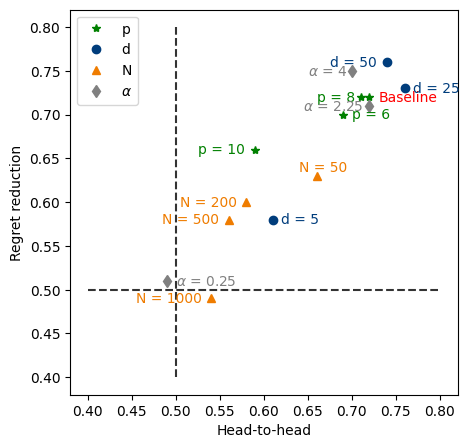

In [23]:
figure_name = DataPath + 'h2h_regret_ddr_ols_all_settings.pdf'
h2h_regret_all_settings(h2h_ddr_ols_prop_p,regret_rd_ddr_ols_prop_p,
                        h2h_ddr_ols_prop_d,regret_rd_ddr_ols_prop_d,
                        h2h_ddr_ols_prop_s,regret_rd_ddr_ols_prop_s,
                        h2h_ddr_ols_prop_alpha,regret_rd_ddr_ols_prop_alpha,
                        figure_name)

In [25]:
h2h_p = h2h_ddr_ols_prop_p
regret_p = regret_rd_ddr_ols_prop_p

h2h_d = h2h_ddr_ols_prop_d
regret_d = regret_rd_ddr_ols_prop_d

h2h_sample_all = h2h_ddr_ols_prop_s
regret_sample_all = regret_rd_ddr_ols_prop_s

h2h_alpha = h2h_ddr_ols_prop_alpha
regret_alpha = regret_rd_ddr_ols_prop_alpha

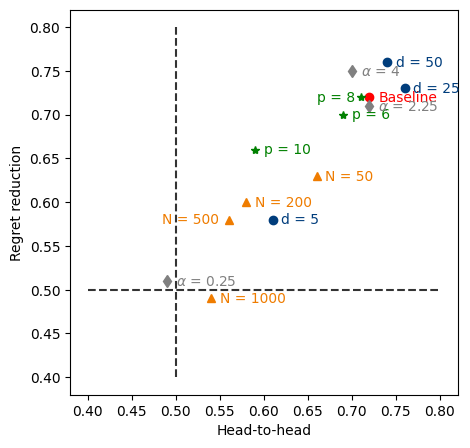

In [58]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (5, 5))
plt.plot(h2h_p[0], regret_p[0], color='red', marker = "o")
plt.plot(h2h_p[1:len(h2h_p)] , regret_p[1:len(regret_p)], color='green', marker = "*", label = 'p', linestyle = 'None')
plt.text(h2h_p[0] + 0.01, regret_p[0] - 0.005, 'Baseline', color='red')

plt.text(h2h_p[1] + 0.01, regret_p[1] - 0.005, 'p = 6', color='green')
plt.text(h2h_p[2] - 0.05, regret_p[2] - 0.005, 'p = 8', color='green')
plt.text(h2h_p[3] + 0.01, regret_p[3] - 0.005, 'p = 10', color='green')

plt.plot(h2h_d[0], regret_d[0], color='#003D7C', marker = "o", label = 'd', linestyle = 'None')
# plt.plot(h2h_d[1], mci_d[1], color='#003D7C', marker = "o", linestyle = 'None')
plt.plot(h2h_d[2], regret_d[2], color='#003D7C', marker = "o", linestyle = 'None')
plt.plot(h2h_d[3], regret_d[3], color='#003D7C', marker = "o", linestyle = 'None')
plt.text(h2h_d[0] + 0.01, regret_d[0] - 0.005, 'd = 5', color='#003D7C')
# plt.text(h2h_d[1] + 0.01, mci_d[1] - 0.003, 'd = 15', color='#003D7C')
plt.text(h2h_d[2] + 0.01, regret_d[2] - 0.005, 'd = 25', color='#003D7C')
plt.text(h2h_d[3] + 0.01, regret_d[3] - 0.005, 'd = 50', color='#003D7C')


plt.plot(h2h_sample_all[0], regret_sample_all[0], color='#EF7C00', marker = "^", label = 'N',linestyle = 'None')
# plt.plot(h2h_N[1], mci_N[1], color='#EF7C00', marker = "^",linestyle = 'None')
plt.plot(h2h_sample_all[2], regret_sample_all[2], color='#EF7C00', marker = "^",linestyle = 'None')
plt.plot(h2h_sample_all[3], regret_sample_all[3], color='#EF7C00', marker = "^",linestyle = 'None')
plt.plot(h2h_sample_all[4], regret_sample_all[4], color='#EF7C00', marker = "^",linestyle = 'None')
plt.text(h2h_sample_all[0] + 0.01, regret_sample_all[0] - 0.005, 'N = 50', color='#EF7C00')
# # plt.text(h2h_N[1] + 0.005, mci_N[1] - 0.003, 'N = 100', color='#EF7C00')
plt.text(h2h_sample_all[2] + 0.01, regret_sample_all[2] - 0.005, 'N = 200', color='#EF7C00')
plt.text(h2h_sample_all[3] - 0.075, regret_sample_all[3] - 0.005, 'N = 500', color='#EF7C00')
plt.text(h2h_sample_all[4] + 0.01, regret_sample_all[4] - 0.005, 'N = 1000', color='#EF7C00')


plt.plot(h2h_alpha[0], regret_alpha[0], color='grey', marker = "d", label = r'$\alpha$',linestyle = 'None')
# plt.plot(h2h_alpha[1], mci_alpha[1], color='grey', marker = "d",linestyle = 'None')
plt.plot(h2h_alpha[2], regret_alpha[2], color='grey', marker = "d",linestyle = 'None')
plt.plot(h2h_alpha[3], regret_alpha[3], color='grey', marker = "d",linestyle = 'None')
plt.text(h2h_alpha[0] + 0.01, regret_alpha[0] - 0.005, r'$\alpha$ = 0.25', color='grey')
# # plt.text(h2h_alpha[1] + 0.005, mci_alpha[1] - 0.005, r'$\alpha$ = 1', color='grey')
plt.text(h2h_alpha[2] + 0.01, regret_alpha[2] - 0.005, r'$\alpha$ = 2.25', color='grey')
plt.text(h2h_alpha[3] + 0.01, regret_alpha[3] - 0.005, r'$\alpha$ = 4', color='grey')

plt.vlines(0.5, 0.4, 0.8, linestyle="dashed", alpha = 0.8,color = 'k')
plt.hlines(0.5, 0.4, 0.8, linestyle="dashed", alpha = 0.8,color = 'k')
# plt.legend()

plt.xlabel('Head-to-head')
plt.ylabel('Regret reduction')

# plt.plot(h2h_sample_all[1], regret_sample_all[1], color='red', marker = "o", linestyle = 'None')
# # plt.annotate('Ridge vs. DDR', xy = (0.25,0.9), xycoords = 'axes fraction', bbox=dict(boxstyle="round", fc="w"), size = 10)

# fig.savefig(DataPath+'DDR_vs_OLS_DPSN.eps', format='eps', bbox_inches="tight")
# fig.savefig(DataPath+'DDR_vs_OLS_DPSN.pdf', format='pdf', bbox_inches="tight")
plt.show()

#### Lasso vs OLS

In [59]:
h2h_p = h2h_lasso_ols_prop_p
regret_p = regret_rd_lasso_ols_prop_p

h2h_d = h2h_lasso_ols_prop_d
regret_d = regret_rd_lasso_ols_prop_d

h2h_sample_all = h2h_lasso_ols_prop_s
regret_sample_all = regret_rd_lasso_ols_prop_s

h2h_alpha = h2h_lasso_ols_prop_alpha
regret_alpha = regret_rd_lasso_ols_prop_alpha

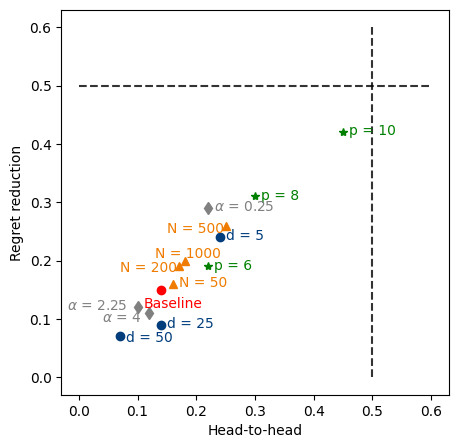

In [95]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (5, 5))
plt.plot(h2h_p[0], regret_p[0], color='red', marker = "o")
plt.plot(h2h_p[1:len(h2h_p)] , regret_p[1:len(regret_p)], color='green', marker = "*", label = 'p', linestyle = 'None')
plt.text(h2h_p[0] -0.03, regret_p[0] - 0.03, 'Baseline', color='red')
plt.text(h2h_p[1] + 0.01, regret_p[1] - 0.005, 'p = 6', color='green')
plt.text(h2h_p[2] + 0.01, regret_p[2] - 0.005, 'p = 8', color='green')
plt.text(h2h_p[3] + 0.01, regret_p[3] - 0.005, 'p = 10', color='green')

plt.plot(h2h_d[0], regret_d[0], color='#003D7C', marker = "o", label = 'd', linestyle = 'None')
# plt.plot(h2h_d[1], mci_d[1], color='#003D7C', marker = "o", linestyle = 'None')
plt.plot(h2h_d[2], regret_d[2], color='#003D7C', marker = "o", linestyle = 'None')
plt.plot(h2h_d[3], regret_d[3], color='#003D7C', marker = "o", linestyle = 'None')
plt.text(h2h_d[0] + 0.01, regret_d[0] - 0.005, 'd = 5', color='#003D7C')
# # plt.text(h2h_d[1] + 0.01, mci_d[1] - 0.003, 'd = 15', color='#003D7C')
plt.text(h2h_d[2] + 0.01, regret_d[2] - 0.005, 'd = 25', color='#003D7C')
plt.text(h2h_d[3] + 0.01, regret_d[3] - 0.01, 'd = 50', color='#003D7C')


plt.plot(h2h_sample_all[0], regret_sample_all[0], color='#EF7C00', marker = "^", label = 'N',linestyle = 'None')
# plt.plot(h2h_N[1], mci_N[1], color='#EF7C00', marker = "^",linestyle = 'None')
plt.plot(h2h_sample_all[2], regret_sample_all[2], color='#EF7C00', marker = "^",linestyle = 'None')
plt.plot(h2h_sample_all[3], regret_sample_all[3], color='#EF7C00', marker = "^",linestyle = 'None')
plt.plot(h2h_sample_all[4], regret_sample_all[4], color='#EF7C00', marker = "^",linestyle = 'None')
plt.text(h2h_sample_all[0] + 0.01, regret_sample_all[0] - 0.005, 'N = 50', color='#EF7C00')
# # # plt.text(h2h_N[1] + 0.005, mci_N[1] - 0.003, 'N = 100', color='#EF7C00')
plt.text(h2h_sample_all[2] - 0.1, regret_sample_all[2] - 0.01, 'N = 200', color='#EF7C00')
plt.text(h2h_sample_all[3] - 0.1, regret_sample_all[3] - 0.0125, 'N = 500', color='#EF7C00')
plt.text(h2h_sample_all[4] - 0.05, regret_sample_all[4] + 0.005, 'N = 1000', color='#EF7C00')


plt.plot(h2h_alpha[0], regret_alpha[0], color='grey', marker = "d", label = r'$\alpha$',linestyle = 'None')
# plt.plot(h2h_alpha[1], mci_alpha[1], color='grey', marker = "d",linestyle = 'None')
plt.plot(h2h_alpha[2], regret_alpha[2], color='grey', marker = "d",linestyle = 'None')
plt.plot(h2h_alpha[3], regret_alpha[3], color='grey', marker = "d",linestyle = 'None')
plt.text(h2h_alpha[0] + 0.01, regret_alpha[0] - 0.005, r'$\alpha$ = 0.25', color='grey')
# # # plt.text(h2h_alpha[1] + 0.005, mci_alpha[1] - 0.005, r'$\alpha$ = 1', color='grey')
plt.text(h2h_alpha[2] - 0.12, regret_alpha[2] - 0.005, r'$\alpha$ = 2.25', color='grey')
plt.text(h2h_alpha[3] - 0.08, regret_alpha[3] - 0.015, r'$\alpha$ = 4', color='grey')

plt.vlines(0.5, 0.0, 0.6, linestyle="dashed", alpha = 0.8,color = 'k')
plt.hlines(0.5, 0.0, 0.6, linestyle="dashed", alpha = 0.8,color = 'k')
# plt.legend()

plt.xlabel('Head-to-head')
plt.ylabel('Regret reduction')

# plt.plot(h2h_sample_all[1], regret_sample_all[1], color='red', marker = "o", linestyle = 'None')
# # plt.annotate('Ridge vs. DDR', xy = (0.25,0.9), xycoords = 'axes fraction', bbox=dict(boxstyle="round", fc="w"), size = 10)

# fig.savefig(DataPath+'DDR_vs_OLS_DPSN.eps', format='eps', bbox_inches="tight")
# fig.savefig(DataPath+'DDR_vs_OLS_DPSN.pdf', format='pdf', bbox_inches="tight")
plt.show()

#### Ridge vs OLS

In [96]:
h2h_p = h2h_ridge_ols_prop_p
regret_p = regret_rd_ridge_ols_prop_p

h2h_d = h2h_ridge_ols_prop_d
regret_d = regret_rd_ridge_ols_prop_d

h2h_sample_all = h2h_ridge_ols_prop_s
regret_sample_all = regret_rd_ridge_ols_prop_s

h2h_alpha = h2h_ridge_ols_prop_alpha
regret_alpha = regret_rd_ridge_ols_prop_alpha

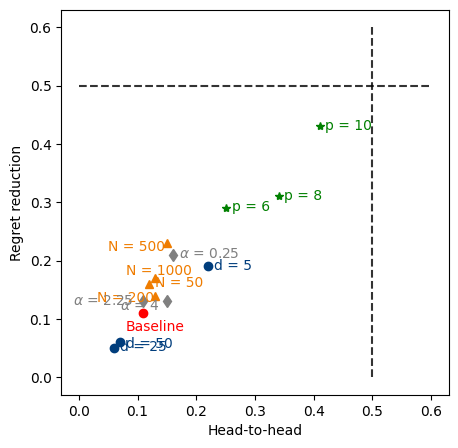

In [97]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (5, 5))
plt.plot(h2h_p[0], regret_p[0], color='red', marker = "o")
plt.plot(h2h_p[1:len(h2h_p)] , regret_p[1:len(regret_p)], color='green', marker = "*", label = 'p', linestyle = 'None')
plt.text(h2h_p[0] -0.03, regret_p[0] - 0.03, 'Baseline', color='red')
plt.text(h2h_p[1] + 0.01, regret_p[1] - 0.005, 'p = 6', color='green')
plt.text(h2h_p[2] + 0.01, regret_p[2] - 0.005, 'p = 8', color='green')
plt.text(h2h_p[3] + 0.01, regret_p[3] - 0.005, 'p = 10', color='green')

plt.plot(h2h_d[0], regret_d[0], color='#003D7C', marker = "o", label = 'd', linestyle = 'None')
# plt.plot(h2h_d[1], mci_d[1], color='#003D7C', marker = "o", linestyle = 'None')
plt.plot(h2h_d[2], regret_d[2], color='#003D7C', marker = "o", linestyle = 'None')
plt.plot(h2h_d[3], regret_d[3], color='#003D7C', marker = "o", linestyle = 'None')
plt.text(h2h_d[0] + 0.01, regret_d[0] - 0.005, 'd = 5', color='#003D7C')
# # plt.text(h2h_d[1] + 0.01, mci_d[1] - 0.003, 'd = 15', color='#003D7C')
plt.text(h2h_d[2] + 0.01, regret_d[2] - 0.005, 'd = 25', color='#003D7C')
plt.text(h2h_d[3] + 0.01, regret_d[3] - 0.01, 'd = 50', color='#003D7C')


plt.plot(h2h_sample_all[0], regret_sample_all[0], color='#EF7C00', marker = "^", label = 'N',linestyle = 'None')
# plt.plot(h2h_N[1], mci_N[1], color='#EF7C00', marker = "^",linestyle = 'None')
plt.plot(h2h_sample_all[2], regret_sample_all[2], color='#EF7C00', marker = "^",linestyle = 'None')
plt.plot(h2h_sample_all[3], regret_sample_all[3], color='#EF7C00', marker = "^",linestyle = 'None')
plt.plot(h2h_sample_all[4], regret_sample_all[4], color='#EF7C00', marker = "^",linestyle = 'None')
plt.text(h2h_sample_all[0] + 0.01, regret_sample_all[0] - 0.005, 'N = 50', color='#EF7C00')
# # # plt.text(h2h_N[1] + 0.005, mci_N[1] - 0.003, 'N = 100', color='#EF7C00')
plt.text(h2h_sample_all[2] - 0.1, regret_sample_all[2] - 0.01, 'N = 200', color='#EF7C00')
plt.text(h2h_sample_all[3] - 0.1, regret_sample_all[3] - 0.0125, 'N = 500', color='#EF7C00')
plt.text(h2h_sample_all[4] - 0.05, regret_sample_all[4] + 0.005, 'N = 1000', color='#EF7C00')


plt.plot(h2h_alpha[0], regret_alpha[0], color='grey', marker = "d", label = r'$\alpha$',linestyle = 'None')
# plt.plot(h2h_alpha[1], mci_alpha[1], color='grey', marker = "d",linestyle = 'None')
plt.plot(h2h_alpha[2], regret_alpha[2], color='grey', marker = "d",linestyle = 'None')
plt.plot(h2h_alpha[3], regret_alpha[3], color='grey', marker = "d",linestyle = 'None')
plt.text(h2h_alpha[0] + 0.01, regret_alpha[0] - 0.005, r'$\alpha$ = 0.25', color='grey')
# # # plt.text(h2h_alpha[1] + 0.005, mci_alpha[1] - 0.005, r'$\alpha$ = 1', color='grey')
plt.text(h2h_alpha[2] - 0.12, regret_alpha[2] - 0.005, r'$\alpha$ = 2.25', color='grey')
plt.text(h2h_alpha[3] - 0.08, regret_alpha[3] - 0.015, r'$\alpha$ = 4', color='grey')

plt.vlines(0.5, 0.0, 0.6, linestyle="dashed", alpha = 0.8,color = 'k')
plt.hlines(0.5, 0.0, 0.6, linestyle="dashed", alpha = 0.8,color = 'k')
# plt.legend()

plt.xlabel('Head-to-head')
plt.ylabel('Regret reduction')

# plt.plot(h2h_sample_all[1], regret_sample_all[1], color='red', marker = "o", linestyle = 'None')
# # plt.annotate('Ridge vs. DDR', xy = (0.25,0.9), xycoords = 'axes fraction', bbox=dict(boxstyle="round", fc="w"), size = 10)

# fig.savefig(DataPath+'DDR_vs_OLS_DPSN.eps', format='eps', bbox_inches="tight")
# fig.savefig(DataPath+'DDR_vs_OLS_DPSN.pdf', format='pdf', bbox_inches="tight")
plt.show()

#### Lasso vs DDR

In [98]:
h2h_p = h2h_lasso_ddr_prop_p
regret_p = regret_rd_lasso_ddr_prop_p

h2h_d = h2h_lasso_ddr_prop_d
regret_d = regret_rd_lasso_ddr_prop_d

h2h_sample_all = h2h_lasso_ddr_prop_s
regret_sample_all = regret_rd_lasso_ddr_prop_s

h2h_alpha = h2h_lasso_ddr_prop_alpha
regret_alpha = regret_rd_lasso_ddr_prop_alpha

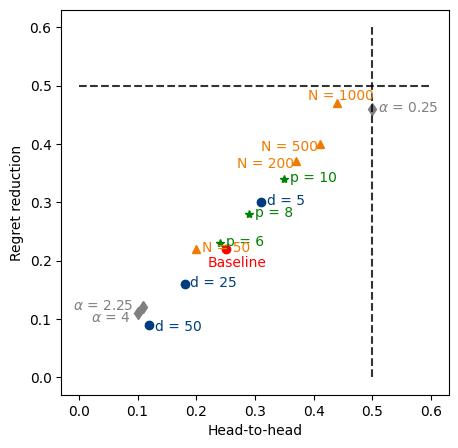

In [99]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (5, 5))
plt.plot(h2h_p[0], regret_p[0], color='red', marker = "o")
plt.plot(h2h_p[1:len(h2h_p)] , regret_p[1:len(regret_p)], color='green', marker = "*", label = 'p', linestyle = 'None')
plt.text(h2h_p[0] -0.03, regret_p[0] - 0.03, 'Baseline', color='red')
plt.text(h2h_p[1] + 0.01, regret_p[1] - 0.005, 'p = 6', color='green')
plt.text(h2h_p[2] + 0.01, regret_p[2] - 0.005, 'p = 8', color='green')
plt.text(h2h_p[3] + 0.01, regret_p[3] - 0.005, 'p = 10', color='green')

plt.plot(h2h_d[0], regret_d[0], color='#003D7C', marker = "o", label = 'd', linestyle = 'None')
# plt.plot(h2h_d[1], mci_d[1], color='#003D7C', marker = "o", linestyle = 'None')
plt.plot(h2h_d[2], regret_d[2], color='#003D7C', marker = "o", linestyle = 'None')
plt.plot(h2h_d[3], regret_d[3], color='#003D7C', marker = "o", linestyle = 'None')
plt.text(h2h_d[0] + 0.01, regret_d[0] - 0.005, 'd = 5', color='#003D7C')
# # plt.text(h2h_d[1] + 0.01, mci_d[1] - 0.003, 'd = 15', color='#003D7C')
plt.text(h2h_d[2] + 0.01, regret_d[2] - 0.005, 'd = 25', color='#003D7C')
plt.text(h2h_d[3] + 0.01, regret_d[3] - 0.01, 'd = 50', color='#003D7C')


plt.plot(h2h_sample_all[0], regret_sample_all[0], color='#EF7C00', marker = "^", label = 'N',linestyle = 'None')
# plt.plot(h2h_N[1], mci_N[1], color='#EF7C00', marker = "^",linestyle = 'None')
plt.plot(h2h_sample_all[2], regret_sample_all[2], color='#EF7C00', marker = "^",linestyle = 'None')
plt.plot(h2h_sample_all[3], regret_sample_all[3], color='#EF7C00', marker = "^",linestyle = 'None')
plt.plot(h2h_sample_all[4], regret_sample_all[4], color='#EF7C00', marker = "^",linestyle = 'None')
plt.text(h2h_sample_all[0] + 0.01, regret_sample_all[0] - 0.005, 'N = 50', color='#EF7C00')
# # # plt.text(h2h_N[1] + 0.005, mci_N[1] - 0.003, 'N = 100', color='#EF7C00')
plt.text(h2h_sample_all[2] - 0.1, regret_sample_all[2] - 0.01, 'N = 200', color='#EF7C00')
plt.text(h2h_sample_all[3] - 0.1, regret_sample_all[3] - 0.0125, 'N = 500', color='#EF7C00')
plt.text(h2h_sample_all[4] - 0.05, regret_sample_all[4] + 0.005, 'N = 1000', color='#EF7C00')


plt.plot(h2h_alpha[0], regret_alpha[0], color='grey', marker = "d", label = r'$\alpha$',linestyle = 'None')
# plt.plot(h2h_alpha[1], mci_alpha[1], color='grey', marker = "d",linestyle = 'None')
plt.plot(h2h_alpha[2], regret_alpha[2], color='grey', marker = "d",linestyle = 'None')
plt.plot(h2h_alpha[3], regret_alpha[3], color='grey', marker = "d",linestyle = 'None')
plt.text(h2h_alpha[0] + 0.01, regret_alpha[0] - 0.005, r'$\alpha$ = 0.25', color='grey')
# # # plt.text(h2h_alpha[1] + 0.005, mci_alpha[1] - 0.005, r'$\alpha$ = 1', color='grey')
plt.text(h2h_alpha[2] - 0.12, regret_alpha[2] - 0.005, r'$\alpha$ = 2.25', color='grey')
plt.text(h2h_alpha[3] - 0.08, regret_alpha[3] - 0.015, r'$\alpha$ = 4', color='grey')

plt.vlines(0.5, 0.0, 0.6, linestyle="dashed", alpha = 0.8,color = 'k')
plt.hlines(0.5, 0.0, 0.6, linestyle="dashed", alpha = 0.8,color = 'k')
# plt.legend()

plt.xlabel('Head-to-head')
plt.ylabel('Regret reduction')

# plt.plot(h2h_sample_all[1], regret_sample_all[1], color='red', marker = "o", linestyle = 'None')
# # plt.annotate('Ridge vs. DDR', xy = (0.25,0.9), xycoords = 'axes fraction', bbox=dict(boxstyle="round", fc="w"), size = 10)

# fig.savefig(DataPath+'DDR_vs_OLS_DPSN.eps', format='eps', bbox_inches="tight")
# fig.savefig(DataPath+'DDR_vs_OLS_DPSN.pdf', format='pdf', bbox_inches="tight")
plt.show()

In [100]:
h2h_p = h2h_ridge_ddr_prop_p
regret_p = regret_rd_ridge_ddr_prop_p

h2h_d = h2h_ridge_ddr_prop_d
regret_d = regret_rd_ridge_ddr_prop_d

h2h_sample_all = h2h_ridge_ddr_prop_s
regret_sample_all = regret_rd_ridge_ddr_prop_s

h2h_alpha = h2h_ridge_ddr_prop_alpha
regret_alpha = regret_rd_ridge_ddr_prop_alpha

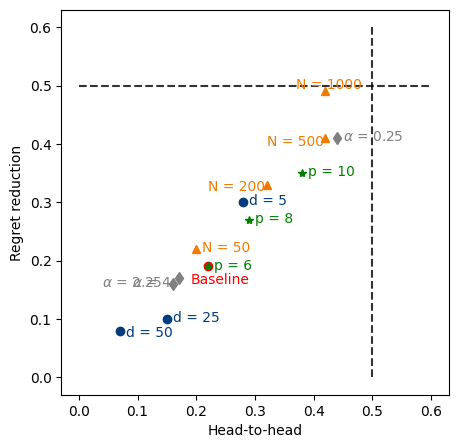

In [101]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (5, 5))
plt.plot(h2h_p[0], regret_p[0], color='red', marker = "o")
plt.plot(h2h_p[1:len(h2h_p)] , regret_p[1:len(regret_p)], color='green', marker = "*", label = 'p', linestyle = 'None')
plt.text(h2h_p[0] -0.03, regret_p[0] - 0.03, 'Baseline', color='red')
plt.text(h2h_p[1] + 0.01, regret_p[1] - 0.005, 'p = 6', color='green')
plt.text(h2h_p[2] + 0.01, regret_p[2] - 0.005, 'p = 8', color='green')
plt.text(h2h_p[3] + 0.01, regret_p[3] - 0.005, 'p = 10', color='green')

plt.plot(h2h_d[0], regret_d[0], color='#003D7C', marker = "o", label = 'd', linestyle = 'None')
# plt.plot(h2h_d[1], mci_d[1], color='#003D7C', marker = "o", linestyle = 'None')
plt.plot(h2h_d[2], regret_d[2], color='#003D7C', marker = "o", linestyle = 'None')
plt.plot(h2h_d[3], regret_d[3], color='#003D7C', marker = "o", linestyle = 'None')
plt.text(h2h_d[0] + 0.01, regret_d[0] - 0.005, 'd = 5', color='#003D7C')
# # plt.text(h2h_d[1] + 0.01, mci_d[1] - 0.003, 'd = 15', color='#003D7C')
plt.text(h2h_d[2] + 0.01, regret_d[2] - 0.005, 'd = 25', color='#003D7C')
plt.text(h2h_d[3] + 0.01, regret_d[3] - 0.01, 'd = 50', color='#003D7C')


plt.plot(h2h_sample_all[0], regret_sample_all[0], color='#EF7C00', marker = "^", label = 'N',linestyle = 'None')
# plt.plot(h2h_N[1], mci_N[1], color='#EF7C00', marker = "^",linestyle = 'None')
plt.plot(h2h_sample_all[2], regret_sample_all[2], color='#EF7C00', marker = "^",linestyle = 'None')
plt.plot(h2h_sample_all[3], regret_sample_all[3], color='#EF7C00', marker = "^",linestyle = 'None')
plt.plot(h2h_sample_all[4], regret_sample_all[4], color='#EF7C00', marker = "^",linestyle = 'None')
plt.text(h2h_sample_all[0] + 0.01, regret_sample_all[0] - 0.005, 'N = 50', color='#EF7C00')
# # # plt.text(h2h_N[1] + 0.005, mci_N[1] - 0.003, 'N = 100', color='#EF7C00')
plt.text(h2h_sample_all[2] - 0.1, regret_sample_all[2] - 0.01, 'N = 200', color='#EF7C00')
plt.text(h2h_sample_all[3] - 0.1, regret_sample_all[3] - 0.0125, 'N = 500', color='#EF7C00')
plt.text(h2h_sample_all[4] - 0.05, regret_sample_all[4] + 0.005, 'N = 1000', color='#EF7C00')


plt.plot(h2h_alpha[0], regret_alpha[0], color='grey', marker = "d", label = r'$\alpha$',linestyle = 'None')
# plt.plot(h2h_alpha[1], mci_alpha[1], color='grey', marker = "d",linestyle = 'None')
plt.plot(h2h_alpha[2], regret_alpha[2], color='grey', marker = "d",linestyle = 'None')
plt.plot(h2h_alpha[3], regret_alpha[3], color='grey', marker = "d",linestyle = 'None')
plt.text(h2h_alpha[0] + 0.01, regret_alpha[0] - 0.005, r'$\alpha$ = 0.25', color='grey')
# # # plt.text(h2h_alpha[1] + 0.005, mci_alpha[1] - 0.005, r'$\alpha$ = 1', color='grey')
plt.text(h2h_alpha[2] - 0.12, regret_alpha[2] - 0.005, r'$\alpha$ = 2.25', color='grey')
plt.text(h2h_alpha[3] - 0.08, regret_alpha[3] - 0.015, r'$\alpha$ = 4', color='grey')

plt.vlines(0.5, 0.0, 0.6, linestyle="dashed", alpha = 0.8,color = 'k')
plt.hlines(0.5, 0.0, 0.6, linestyle="dashed", alpha = 0.8,color = 'k')
# plt.legend()

plt.xlabel('Head-to-head')
plt.ylabel('Regret reduction')

# plt.plot(h2h_sample_all[1], regret_sample_all[1], color='red', marker = "o", linestyle = 'None')
# # plt.annotate('Ridge vs. DDR', xy = (0.25,0.9), xycoords = 'axes fraction', bbox=dict(boxstyle="round", fc="w"), size = 10)

# fig.savefig(DataPath+'DDR_vs_OLS_DPSN.eps', format='eps', bbox_inches="tight")
# fig.savefig(DataPath+'DDR_vs_OLS_DPSN.pdf', format='pdf', bbox_inches="tight")
plt.show()